In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import pandas as pd
import plotly as py
# import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
from itertools import product
import scipy as sp
from scipy.special import expit

from compton import expansion_parameter, expansion_parameter_cm
from compton import mass_proton, mass_neutron, alpha_fine, hbarc, fm2_to_nb
from compton import setup_rc_params

%matplotlib inline

In [2]:
# mpl.rcParams['figure.dpi'] = 180
# mpl.rcParams['font.size'] = 9
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.family'] = 'serif'

# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')
setup_rc_params()


In [3]:
# Make sure these are right
# mass_proton = 938.272
# alpha_fine = 0.00729735256
# hbarc = 197.326
# fm2_to_nb = 1e7  # I think

In [4]:
def expansion_parameter(X, breakdown):
    X = np.atleast_2d(X)
    m_pi = 138
    return np.squeeze((X[:, 0] + m_pi) / breakdown)

def expansion_parameter2(X, breakdown):
    X = np.atleast_2d(X)
    m_pi = 138
    omega_lab_pi = 149.95
    xx_pi = (X[:, 0] - omega_lab_pi) / 20
    cusp_factor = 2 / (np.abs(np.arctan(xx_pi)) + 0.5)
    return np.squeeze((X[:, 0] + m_pi) * cusp_factor / breakdown)


def thompson_limit(degrees):
    return (alpha_fine * hbarc / mass_proton)**2 * fm2_to_nb * \
        (1 + np.cos(np.pi * degrees / 180)**2) / 2


def coefficients(y, ratio, ref=1, orders=None):
    """Returns the coefficients of a power series

    Parameters
    ----------
    y : array, shape = (n_samples, n_curves)
    ratio : scalar or array, shape = (n_samples,)
    ref : scalar or array, shape = (n_samples,)
    orders : 1d array, optional
        The orders at which y was computed. Defaults to 0, 1, ..., n_curves-1

    Returns
    -------
    An (n_samples, n_curves) array of the extracted coefficients
    """
    if y.ndim != 2:
        raise ValueError('y must be 2d')
    if orders is None:
        orders = np.arange(y.shape[-1])
    if orders.shape[-1] != y.shape[-1]:
        raise ValueError('partials and orders must have the same length')

    ref, ratio, orders = np.atleast_1d(ref, ratio, orders)
    ref = ref[:, None]
    ratio = ratio[:, None]

    # Make coefficients
    coeffs = np.diff(y, axis=-1)                       # Find differences
    coeffs = np.insert(coeffs, 0, y[..., 0], axis=-1)  # But keep leading term
    coeffs = coeffs / (ref * ratio**orders)            # Scale each order appropriately
    return coeffs

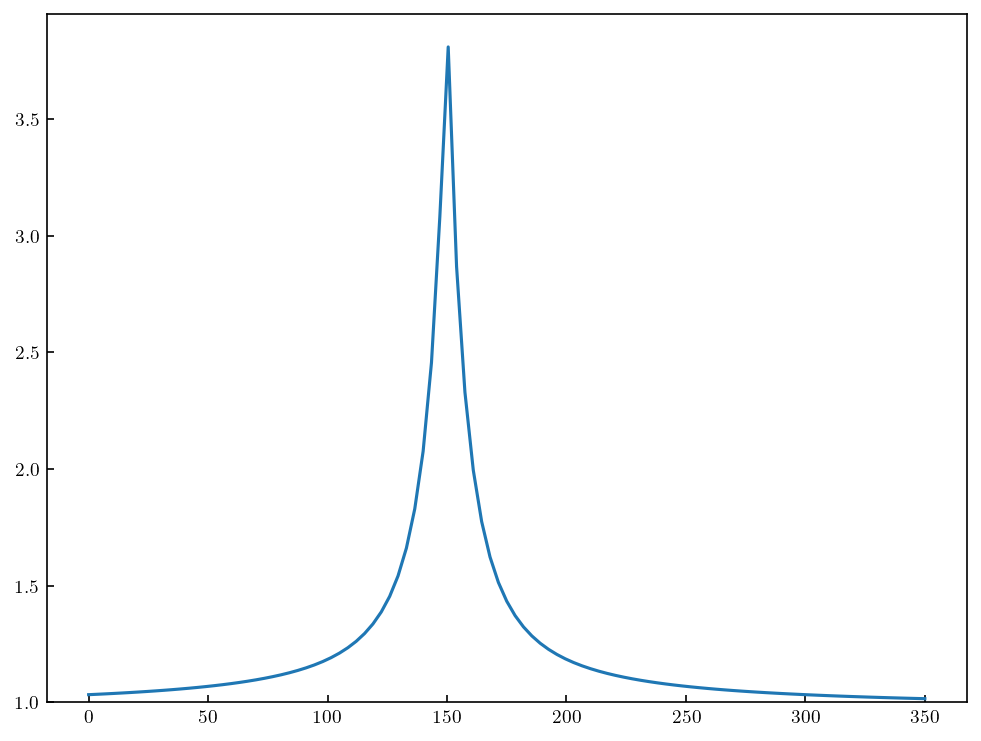

In [5]:
xx = np.linspace(0, 350, 101)
plt.plot(xx, 2/(np.abs(np.arctan((xx-150)/20)) + 0.5))
plt.ylim(1, None);

In [6]:
df = pd.read_csv('../data/compton_observables.csv', index_col=False)

# obs vals: crosssection, 1Xp, 1X, 1Zp, 1Z, 2Xp, 2X, 2Zp, 2Z, 3, 3Yp, 3Y, Y
obs_vals = [
    'crosssection', '1Xp', '1X', '1Zp', '1Z', '2Xp',
    '2X', '2Zp', '2Z', '3', '3Yp', '3Y', 'Y'
]
# obs_vals = [
#     'crosssection'
# ]
systems = ['neutron', 'proton']

In [7]:
orders = np.array([0, 2, 3, 4])

Show a logistic plot and the Delta regime

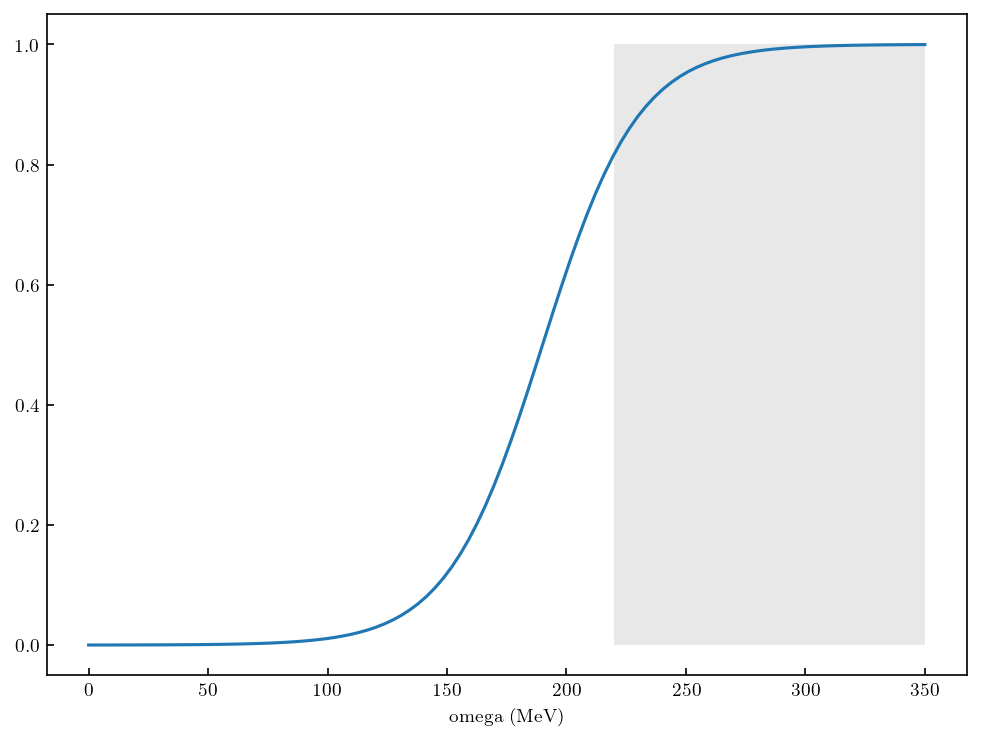

In [8]:
x = np.linspace(0, 350, 100)

plt.plot(x, expit((x-190)/20))
plt.fill_between([220, 350], [1, 1], [0, 0], facecolor='lightgrey', alpha=0.5)
plt.xlabel('omega (MeV)');

In [9]:
def order_transition(n, n_inf, omega):
    return n + (n_inf - n) * expit((omega-190)/20)

In [10]:
def order_transition2(n, omega):
    omega1 = 180.
    omega2 = 240.
    omegam = (omega1 + omega2) / 2.
    f = 1. / (1 + np.exp(4 * np.log(3) * (omega - omegam) / (omega1 - omega2)))
    if n % 2 == 0:
        return (1 - f / 2.) * n
    elif n % 2 == 1:
        return (1 - f / 2.) * n - 5 * f / 2.
    raise ValueError('n must be an integer')
    
def order_transition3(n, omega, n_inf):
    omega1 = 180.
    omega2 = 240.
    omegam = (omega1 + omega2) / 2.
    f = 1. / (1 + np.exp(4 * np.log(3) * (omega - omegam) / (omega1 - omega2)))
    return n - (n - n_inf) * f

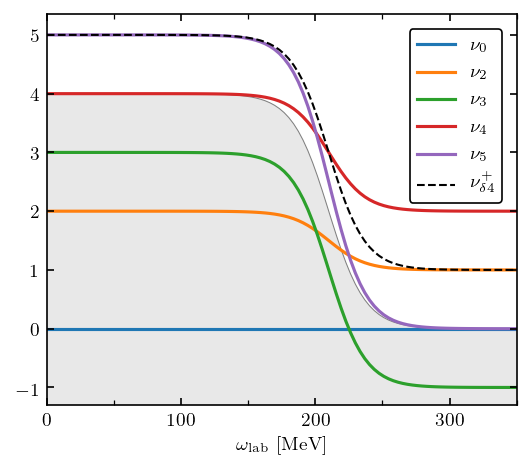

In [13]:
# order_map = {0: 0, 2: 1, 3: -1, 4: 2}
fig, ax = plt.subplots(figsize=(3.4, 3))

for order in [0, 2, 3, 4, 5]:
    ax.plot(x, order_transition2(order, x), label=fr'$\nu_{{{order}}}$', zorder=order/5)

ax.plot(x, order_transition3(5, x, 1), c='k', ls='--', lw=1, label=r'$\nu_{\delta 4}^+$', zorder=2)
ax.set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax.set_ylabel('EFT Order')
ax.legend()
ax.tick_params(right=True, top=True, direction='in', which='both')
# ax.fill_between([220, 350], [5, 5], [-1, -1], facecolor='lightgrey', alpha=0.5)
plt.fill_between(x, -2*np.ones(x.shape), order_transition3(5, x, 1)-1,
                 facecolor='lightgrey', alpha=0.5, zorder=-1)
ax.plot(x, order_transition3(5, x, 1)-1, c='gray', lw=0.5, zorder=-1)
ax.set_xlim(x[0], x[-1])
ax.set_ylim(-1.3, None)
# fig.tight_layout()
fig.savefig('manuscript_figures/eft_order_transition.png')

In [ ]:
order_map = {0: 0, 2: 1, 3: -1, 4: 2}

for order in orders:
    plt.plot(x, order_transition(order, order_map[order], x), label=f'Exponent {order}')
    plt.xlabel('omega (MeV)')
    plt.legend()
plt.tick_params(right=True, direction='in')
plt.fill_between([220, 350], [4, 4], [-1, -1], facecolor='lightgrey', alpha=0.5);

In [ ]:
df_rescaled = df.copy()
groups = df_rescaled.groupby(['observable', 'nucleon'])
obs_labels = ['y0', 'y2', 'y3', 'y4']

for obs, nucleon in groups.groups:
    print(obs, nucleon)
    mask = (df_rescaled['observable'] == obs) & (df_rescaled['nucleon'] == nucleon)
    dsg_mask = (df_rescaled['observable'] == 'crosssection') & (df_rescaled['nucleon'] == nucleon)
    if obs != 'crosssection':
        df_rescaled.loc[mask, obs_labels] *= df_rescaled[dsg_mask][obs_labels].values / df_rescaled[dsg_mask]['y4'].values[:, None]

In [ ]:
obs, system = 'Y', 'proton'

print(obs, system)
df_obs = df[(df['observable'] == obs) & (df['nucleon'] == system)]
# df_obs = df_rescaled[(df_rescaled['observable'] == obs) & (df_rescaled['nucleon'] == system)]
X = df_obs[['omegalab [MeV]', 'thetalab [deg]']].values
omega = np.unique(X[:, 0])
degrees = np.unique(X[:, 1])

mass = mass_proton

Lambdab = 650
# Q = expansion_parameter2(X, Lambdab)
Q = expansion_parameter_transfer_cm(X, Lambdab, mass)
ord_vals = np.array([order_transition(order, order_map[order], X[:, 0]) for order in orders]).T
# ord_vals = orders
y = df_obs[['y0', 'y2', 'y3', 'y4']].values
y_grid = y.reshape(len(omega), len(degrees), -1)
ref = 1.
if obs == 'crosssection':
    ref = df_obs['y4'].values
coeffs = coefficients(y, ratio=Q, orders=ord_vals, ref=ref)
coeffs_grid = coeffs.reshape(len(omega), len(degrees), -1)
# coeffs_grid = y.reshape(len(omega), len(degrees), -1)

In [ ]:
np.any(np.isnan(y))

In [ ]:
coeffs_grid[0, :, -1]

In [ ]:
coeffs_grid[0, :, -3]

In [ ]:
def discrete_colorscale(bvals, colors):
    """
    bvals - list of values bounding intervals/ranges of interest
    colors - list of rgb or hex colorcodes for values in [bvals[k], bvals[k+1]],0<=k < len(bvals)-1
    returns the plotly  discrete colorscale
    """
    if len(bvals) != len(colors)+1:
        raise ValueError('len(boundary values) should be equal to  len(colors)+1')
    bvals = sorted(bvals)     
    nvals = [(v-bvals[0])/(bvals[-1]-bvals[0]) for v in bvals]  # normalized values
    
    dcolorscale = []  # discrete colorscale
    for k in range(len(colors)):
        dcolorscale.extend([[nvals[k], colors[k]], [nvals[k+1], colors[k]]])
    return dcolorscale 

In [ ]:
data = []
names = ['c{}'.format(i) for i in orders]
n_names = len(names)

colorscale = discrete_colorscale(
    np.arange(n_names+1)/n_names,
    colors=[mpl.colors.to_hex('C{}'.format(i)) for i in range(n_names)]
)
print(colorscale)

for i, name in enumerate(names):
    col = mpl.colors.to_hex('C{}'.format(i))
    z = coeffs_grid[..., i].T
#     surf = go.Surface(
#         z=coeffs_grid[..., i].T, x=omega, y=degrees, name=name,
#         showscale=False, opacity=1., colorscale=[[0, col], [1, col]],
#     )
    surf = go.Surface(
        z=z, x=omega, y=degrees, name=name,
        showscale=False, #opacity=1.,
        surfacecolor=i / n_names * np.ones_like(z),
        cmin=0, cmax=(n_names-1)/n_names,
        colorscale=colorscale,
    )
#     surf = go.Scatter3d(
#         z=coeffs_grid[..., i].T.ravel(),
#         x=X[:, 0], y=X[:, 1],
#         name=name,
#         line=go.scatter3d.Line(color=col),
#         surfaceaxis=2, surfacecolor=col,
#         showlegend=True, mode='lines',
#     )
    # This adds a corresponding legend, since surfaces don't have them
#     placeholder = go.Scatter3d(
#         z=[None], x=[None], y=[None], name=name,
#         line=go.scatter3d.Line(color=col),
#         surfaceaxis=2, surfacecolor=col,
#         showlegend=True, mode='lines',
#     )
    data.append(surf)
#     data.append(placeholder)

# layout = go.Layout(
#     title=f'{obs} {system} coefficients',
#     showlegend=True,
#     autosize=False,
#     width=1100,
#     height=700,
#     scene=dict(
#         xaxis=dict(
#             title='Energy',
#             range=[omega.min(), np.max(omega)],
# #             range=[0,10]
#         ),
#         yaxis=dict(
#             title=r'Degrees',
#             range=[degrees.min(), degrees.max()],
# #             range=[0, 2]
#         ),
#         zaxis=dict(
#             range=[coeffs_grid.min(), coeffs_grid.max()]
# #             range=[-10, 10]
# #             range=[0, 0.02]
#         ),
#     ),
# )
fig = go.FigureWidget(data=data, #layout=layout
                     )
fig.show()

# This is to connect the placeholder legend to the surface
# To permit toggling surfaces on/off

# #####################################################################
# # None of this will work outside of a Jupyter notebook
# surfaces = {s.name: s for s in fig.data if isinstance(s, go.Surface)}
# placeholders = {p.name: p for p in fig.data if isinstance(p, go.Scatter3d)}

# def update_surface_visibility(trace, visible):
#     surfaces[trace.name].visible = visible

# [p.on_change(update_surface_visibility, 'visible')
#  for p in placeholders.values()]
# fig.show()
# #####################################################################

# fig.write_html(f'figures_interactive/coeffs_sys-{system}_obs-{obs}.html',
#                include_plotlyjs='directory')

Most of the problems observed in the spins observable coefficients are coming from the differential cross section convergence. This creates multiplicative errors in the spin observables.

In [ ]:
from plotly.subplots import make_subplots

obs_vals = [
    'crosssection', '1Xp', '1X', '1Zp', '1Z', '2Xp',
    '2X', '2Zp', '2Z', '3', '3Yp', '3Y', 'Y'
]

# systems = ['neutron', 'proton']
nucleon = 'neutron'
nrows = len(obs_vals) // 2 + len(obs_vals) % 2

specs = [[{'type': 'surface'}, {'type': 'surface'}] for i in range(nrows)]
print(specs)

fig = make_subplots(
    rows=nrows , cols=2,
    specs=specs,
#     subplot_titles=[f'{obs} {nucleon}' for obs in obs_vals for nucleon in systems],
    subplot_titles=[f'{obs} {nucleon}' for obs in obs_vals],
    horizontal_spacing=0.05,
    vertical_spacing=2e-2,
)

print([f'{obs} {nucleon}' for obs in obs_vals for nucleon in systems])
scene_idx = 0
for i, obs in enumerate(obs_vals):
#         row = i + 1
#         col = j + 1
    col = i % 2 + 1
    row = i // 2 + 1

    df_obs = df[(df['observable'] == obs) & (df['nucleon'] == nucleon)]
    # df_obs = df_rescaled[(df_rescaled['observable'] == obs) & (df_rescaled['nucleon'] == system)]
    X = df_obs[['omegalab [MeV]', 'thetalab [deg]']].values
    omega = np.unique(X[:, 0])
    degrees = np.unique(X[:, 1])

    mass = mass_proton if nucleon == 'proton' else mass_neutron

    Lambdab = 650
    # Q = expansion_parameter2(X, Lambdab)
    Q = expansion_parameter_transfer_cm(X, Lambdab, mass)
    ord_vals = np.array([order_transition(order, order_map[order], X[:, 0]) for order in orders]).T
    # ord_vals = orders
    y = df_obs[['y0', 'y2', 'y3', 'y4']].values
    y_grid = y.reshape(len(omega), len(degrees), -1)
    ref = 1.
    if obs == 'crosssection':
        ref = df_obs['y4'].values
    coeffs = coefficients(y, ratio=Q, orders=ord_vals, ref=ref)
    coeffs_grid = coeffs.reshape(len(omega), len(degrees), -1)


    data = []
    names = ['c{}'.format(i) for i in orders]
    for k, name in enumerate(names):
        color = mpl.colors.to_hex('C{}'.format(k))
        z = coeffs_grid[..., k].T
        n_skip = 2
        surf = go.Surface(
            z=z[::n_skip, ::n_skip], x=omega[::n_skip], y=degrees[::n_skip], name=name,
            showscale=False, opacity=1., colorscale=[[0, color], [1, color]],
        )
#             surf = go.Surface(
#                 z=z, x=omega, y=degrees, name=name,
#                 showscale=False, #opacity=1.,
#                 surfacecolor=k / n_names * np.ones_like(z),
#                 cmin=0, cmax=(n_names-1)/n_names,
#                 colorscale=colorscale,
#             )
        fig.add_trace(surf, row=row, col=col)
    if scene_idx == 0:
        scene_i = 'scene'
    else:
        scene_i = f'scene{scene_idx}'  
    scene_idx += 1
    fig.update_layout({scene_i: dict(xaxis_title="omega lab [MeV]", yaxis_title="theta lab [deg]", aspectmode='cube')})
        
        
# xaxis=dict(
#             title='Energy',
#             range=[omega.min(), np.max(omega)],
# #             range=[0,10]
#         ),
#         yaxis=dict(
#             title=r'Degrees',
#             range=[degrees.min(), degrees.max()],
# #             range=[0, 2]
#         ),

fig.update_layout(height=3700, width=1400, title_text="Coefficients")

# print(fig)

fig.write_html(f'../scripts/figures_interactive/all_{nucleon}_coeffs.html',
               include_plotlyjs='directory')
# fig.show()

In [ ]:
test_nrows = 13
test_ncols = 1

fig = make_subplots(
    rows=test_nrows, cols=test_ncols,
#     specs=[[{'type': 'surface'}, {'type': 'surface'}] for n in range(test_nrows)],
#     specs=[[{'type': 'scatter'}, {'type': 'scatter'}] for n in range(test_nrows)],
    specs=[[{'type': 'scene'} for nc in range(test_ncols)] for n in range(test_nrows)],
    subplot_titles=[f'test {i}, {j}' for i in range(test_nrows) for j in range(test_ncols)],
)

# Generate data
x = np.linspace(-5, 80, 10)
y = np.linspace(-5, 60, 10)
xGrid, yGrid = np.meshgrid(y, x)
z = xGrid ** 3 + yGrid ** 3

z_flat = x**3 + y**3

# adding surfaces to subplots.
for i in range(test_nrows):
    for j in range(test_ncols):
#         fig.add_trace(
#             go.Surface(x=x, y=y, z=z, colorscale='Viridis', showscale=False),
#             row=i+1, col=j+1)
        fig.add_trace(
            go.Scatter3d(x=x, y=y, z=z_flat),
            row=i+1, col=j+1)

fig.update_layout(height=5000, width=1000, title_text="Test")
fig.show()